## Process eval score

In [127]:

import json
import re
import os
import pandas as pd

df_eval = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
df_tp = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
df_tn = pd.DataFrame(columns=["model_name", "mode", "mission_name", "true_negative"])
tn_dict = [{} for i in range(5)]
eval_dict = [{} for i in range(5)]

save_csv_dir = "csv_data"

if not os.path.exists(save_csv_dir):
    os.makedirs(save_csv_dir)
    
save_pic_dir = "pictures"

if not os.path.exists(save_pic_dir):
    os.makedirs(save_pic_dir)

input_dir = "./pred"

flag = 1 # 1: llama 0: internlm
model_names = ["internlm-7b-8k", "llama2-7b-chat-4k"]

modes0 = ["internlm-7b-8k_no_g0.1_d10.0", "llama2-7b-chat-4k_no_g0.5_d5.0"]
modes1 = ["internlm-7b-8k_old_hard_g0.15_d10.0", "llama2-7b-chat-4k_old_hard_g0.25_d5.0"]
modes2 = ["internlm-7b-8k_old_soft_g0.1_d10.0", "llama2-7b-chat-4k_old_soft_g0.1_d10.0"]
modes3 = ["internlm-7b-8k_gpt_g0.25_d15.0", "llama2-7b-chat-4k_gpt_g0.1_d10.0"]
modes4 = ["internlm-7b-8k_v2_g0.1_d10.0", "llama2-7b-chat-4k_v2_g0.25_d15.0"]

all_modes = [modes0, modes1, modes2, modes3, modes4]
# model_name = "internlm-7b-8k"

# mode0 = "internlm-7b-8k_no_g0.1_d10.0"
# mode1 = "internlm-7b-8k_old_hard_g0.15_d10.0"
# mode2 = "internlm-7b-8k_old_soft_g0.1_d10.0"
# mode3 = "internlm-7b-8k_gpt_g0.25_d15.0"
# mode4 = "internlm-7b-8k_v2_g0.1_d10.0"
# mode_default = [mode0, mode1, mode2, mode3, mode4]

# if flag == 1:
#     model_name = "llama2-7b-chat-4k"
    
#     mode0 = "llama2-7b-chat-4k_no_g0.5_d5.0"
#     mode1 = "llama2-7b-chat-4k_old_hard_g0.25_d5.0"
#     mode2 = "llama2-7b-chat-4k_old_soft_g0.1_d10.0"
#     mode3 = "llama2-7b-chat-4k_gpt_g0.1_d10.0"
#     mode4 = "llama2-7b-chat-4k_v2_g0.25_d15.0"
    
model_name = model_names[flag]
mode = [modes_i[flag] for modes_i in all_modes]

mutual_mode = ["_".join(modex.split("_")[1:]) for modex in mode]
print(mutual_mode)

num_eval = 0
num_z = 0
p = r"(?P<model_name>.+)_(?P<mode>old|v2|gpt|new|no)_g(?P<gamma>.+)_d(?P<delta>\d+(\.\d+)?)"
p_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<gamma>\d+(\.\d+)?)_(?P<delta>.+)_z"
p_mutual_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<threshold>\d+(\.\d+)?)_z"

['no_g0.5_d5.0', 'old_hard_g0.25_d5.0', 'old_soft_g0.1_d10.0', 'gpt_g0.1_d10.0', 'v2_g0.25_d15.0']


### Get TP and Eval

In [128]:
# get all files from input_dir
for subfolder in os.listdir(input_dir):
    
    if "human" in subfolder:
        continue
    matcher = re.match(p, subfolder)
    
    model_name_now = matcher.group("model_name")
    if model_name_now != model_name:
        continue
    print("subfolder is:", subfolder)
    mode = matcher.group("mode")
    gamma = matcher.group("gamma")
    delta = matcher.group("delta")
    
    bl_type = "None"
    bl_type = (subfolder.split("_")[-1]).split(".")[0]
    
    if bl_type != "hard":
        if "old" in subfolder:
            bl_type = "soft"
        else:
            bl_type = "None"
        
    if bl_type == "hard" or bl_type == "soft":
        final_mode = model_name + "_" + mode + "_" + bl_type + "_" + "g"+gamma + "_" + "d" + delta  
    else:
        final_mode = model_name + "_" + mode + "_" + "g"+gamma + "_" + "d" + delta 
        
    eval_path = os.path.join(input_dir, subfolder, "eval")
    z_score_path = os.path.join(input_dir, subfolder, "z_score")
    threshold = 4.0
    if os.path.exists(z_score_path):
        temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
        all_z = []
        all_sum = []
        all_tp = 0
        
        
        files = os.listdir(z_score_path)
        for file in files:
            tp = 0
            matcher1 = re.match(p_z, file)
            
            if matcher1:
                mission_name = matcher1.group("mission_name")
            
            with open(os.path.join(z_score_path, file), "r") as f:
                data = json.load(f) 
                
            z_score_list = data["z_score_list"]
            _sum = len(data["z_score_list"])   
            tp += len([x for x in z_score_list if x > threshold])
            avarage_z = data["avarage_z"]
            temp = pd.DataFrame({
                "model_name": [model_name],
                "mode": [final_mode],
                "mission_name": [mission_name],
                "z_score": [avarage_z],
                "true_positive": [tp/_sum],
                "sum": [_sum]})
            
            df_tp = pd.concat([df_tp, temp], ignore_index=True)
            all_z.append(avarage_z * _sum)
            all_sum.append(_sum)
            all_tp += tp
            num_z += 1
            
        temp_df = pd.DataFrame({
            "model_name": [model_name],
            "mode": [final_mode],
            "mission_name": ["avarage_mode"],
            "z_score": [sum(all_z) / sum(all_sum)],
            "true_positive": [all_tp/sum(all_sum)], 
            "sum": [all_sum]
        })
        df_tp = pd.concat([df_tp, temp_df], ignore_index=True)   
         
    if os.path.exists(eval_path):
        result_file = os.path.join(eval_path, "result.json")
        if os.path.exists(result_file):
            with open (result_file, "r") as f:
                data = json.load(f)
            keys = data.keys()
            temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
            all_scores = []
            for key in keys:
                eval_score = float((str(data[key])).split(" ")[-1])
                temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": [key],
                    "score":[eval_score]
                })
                
                all_scores.append(eval_score)
                df_eval = pd.concat([df_eval, temp_df], ignore_index=True)
                
                num_eval += 1
                
            temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": ["avarage_mode"],
                    "score":[sum(all_scores) / len(keys)]
                })   
            
            df_eval = pd.concat([df_eval, temp_df], ignore_index=True) 
            

subfolder is: llama2-7b-chat-4k_gpt_g0.25_d10.0
subfolder is: llama2-7b-chat-4k_v2_g0.1_d2.0
subfolder is: llama2-7b-chat-4k_gpt_g0.1_d10.0
subfolder is: llama2-7b-chat-4k_old_g0.25_d15.0_hard
subfolder is: llama2-7b-chat-4k_old_g0.75_d5.0_hard
subfolder is: llama2-7b-chat-4k_v2_g0.25_d2.0
subfolder is: llama2-7b-chat-4k_old_g0.5_d2.0_hard
subfolder is: llama2-7b-chat-4k_old_g0.25_d5.0_hard
subfolder is: llama2-7b-chat-4k_gpt_g0.5_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.1_d5.0
subfolder is: llama2-7b-chat-4k_v2_g0.25_d10.0
subfolder is: llama2-7b-chat-4k_v2_g0.1_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.25_d10.0_hard
subfolder is: llama2-7b-chat-4k_v2_g0.9_d5.0
subfolder is: llama2-7b-chat-4k_gpt_g0.9_d2.0
subfolder is: llama2-7b-chat-4k_gpt_g0.25_d2.0
subfolder is: llama2-7b-chat-4k_old_g0.75_d15.0
subfolder is: llama2-7b-chat-4k_old_g0.5_d2.0
subfolder is: llama2-7b-chat-4k_gpt_g0.5_d2.0
subfolder is: llama2-7b-chat-4k_v2_g0.75_d10.0
subfolder is: llama2-7b-chat-4k_gpt_g0.9_d5.

In [129]:
df_tp.to_csv(os.path.join(save_csv_dir, f"z_score_tp_{model_name}.csv"))           
print(df_tp)
print(num_z)

df_eval = df_eval.sort_values(by="mode", ascending=True)                 
df_eval.to_csv(os.path.join(save_csv_dir, f"eval_{model_name}.csv"))                
print("num is:", num_eval)

            model_name                                   mode  \
0    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
1    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
2    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
3    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
4    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
..                 ...                                    ...   
618  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
619  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
620  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
621  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
622  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   

               mission_name    z_score  true_positive  \
0                     qmsum  18.372595       0.970000   
1                alpacafarm  24.303930       0.962733   
2                  hotpotqa   2.740259       0.2

### Calculate TN

In [130]:
input_dir = f"./mutual_detect/{model_name}/"

df_mutual = pd.DataFrame(columns=["model_name", "mission_name", "ref_mode", "det_mode", "threshold", "z_score", "true_negative", "sum", "tn_num"])

num = 0
for subfolder in os.listdir(input_dir):
    ref_mode = "_".join(subfolder.split("_")[1:])
    print("ref_mode is", ref_mode)
    if ref_mode in mutual_mode:
        print("mode_des is", ref_mode)
        
        for subsubfolder in os.listdir(os.path.join(input_dir,subfolder)):
            det_mode = subsubfolder.split("_z")[0]
            print(det_mode)
            
            z_score_path = os.path.join(input_dir, subfolder, subsubfolder)
            if os.path.exists(z_score_path):
                files = os.listdir(z_score_path)
                
                all_z = []
                all_sum = []
                all_tn = 0
                
                for file in files:
                    tn = 0
                    matcher2 = re.match(p_mutual_z, file)
                    if matcher2:
                        mission_name = matcher2.group("mission_name")
                        threshold = float(matcher2.group("threshold"))
                        
                    with open(os.path.join(z_score_path, file), "r") as f:
                        data = json.load(f)
                        
                        
                    avarage_z = data["avarage_z"]
                    z_score_list = data["z_score_list"]
                    _sum = len(data["z_score_list"])
                    
                    tn += len([x for x in z_score_list if x <= threshold])
                    num += 1
                    
                    temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": [mission_name],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [avarage_z],
                        "true_negative": [tn/_sum],
                        "tn_num": [tn],
                        "sum": [_sum]
                    })
                    all_tn += tn
                    all_z.append(avarage_z * _sum)
                    all_sum.append(_sum)
                    
                    df_mutual = pd.concat([df_mutual, temp_df], ignore_index=True)
                temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": ["avarage_mode"],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [sum(all_z) / sum(all_sum)],
                        "true_negative": [all_tn/sum(all_sum)],
                        "tn_num": [all_tn],
                        "sum": [sum(all_sum)]
                    })
                
                df_mutual = pd.concat([df_mutual, temp_df], ignore_index=True)
                    
df_mutual.to_csv(os.path.join(save_csv_dir, f"mutual_z_contri_{model_name}.csv"))

ref_mode is gpt_g0.25_d15.0
ref_mode is old_soft_g0.1_d10.0
mode_des is old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
ref_mode is v2_g0.25_d10.0
ref_mode is old_hard_g0.25_d5.0
mode_des is old_hard_g0.25_d5.0
old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
ref_mode is old_hard_g0.5_d2.0
ref_mode is old_soft_g0.25_d15.0
ref_mode is gpt_g0.1_d10.0
mode_des is gpt_g0.1_d10.0
old_soft_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
ref_mode is old_soft_g0.25_d2.0
ref_mode is v2_g0.25_d15.0
mode_des is v2_g0.25_d15.0
old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0


### Human_Generation TN

In [131]:
df_det_human = df_mutual.loc[(df_mutual["det_mode"] == "human_generation")]
df_det_human.sort_values(by="ref_mode")
df_det_human.to_csv(os.path.join(save_csv_dir, f"human_tn_{model_name}.csv"))

df_det_human

,model_name,mission_name,ref_mode,det_mode,threshold,z_score,true_negative,sum,tn_num
10,llama2-7b-chat-4k,multi_news,old_soft_g0.1_d10.0,human_generation,4.0,-0.112484,1.000000,200,200
11,llama2-7b-chat-4k,alpacafarm,old_soft_g0.1_d10.0,human_generation,4.0,0.036781,0.988750,800,791
12,llama2-7b-chat-4k,lcc,old_soft_g0.1_d10.0,human_generation,4.0,0.005696,1.000000,200,200
13,llama2-7b-chat-4k,longform_qa,old_soft_g0.1_d10.0,human_generation,4.0,0.172552,1.000000,200,200
14,llama2-7b-chat-4k,konwledge_memorization,old_soft_g0.1_d10.0,human_generation,4.0,0.053491,0.993056,144,143
15,llama2-7b-chat-4k,konwledge_understanding,old_soft_g0.1_d10.0,human_generation,4.0,0.157502,0.979798,99,97
16,llama2-7b-chat-4k,hotpotqa,old_soft_g0.1_d10.0,human_generation,4.0,0.238792,1.000000,164,164
17,llama2-7b-chat-4k,finance_qa,old_soft_g0.1_d10.0,human_generation,4.0,0.014957,1.000000,200,200
18,llama2-7b-chat-4k,qmsum,old_soft_g0.1_d10.0,human_generation,4.0,0.049565,1.000000,200,200
19,llama2-7b-chat-4k,avarage_mode,old_soft_g0.1_d10.0,human_generation,4.0,0.053439,0.994563,2207,2195


### Get True_Negative

In [132]:
# get the row with the same ref_mode and mission_name, take the mean of their sum(true_negative * _sum)/sum(_sum)
grouped = df_mutual.groupby(["model_name", "mission_name", "ref_mode"]).agg({"tn_num": lambda x: x.sum(), "sum": lambda x: x.sum()})
print(grouped)
grouped["true_negative"] = grouped["tn_num"] / grouped["sum"]

print(grouped.columns)
print(grouped.index.get_level_values("model_name"))

grouped.to_csv(os.path.join(save_csv_dir, f"process_z_{model_name}.csv"))
# 改为只计算human_true_negative
df_tn = pd.read_csv(f"{save_csv_dir}/human_tn_{model_name}.csv")
# df_tn["model_name"] = grouped.index.get_level_values("model_name")
# 
# df_tn["mode"] = grouped.index.get_level_values("ref_mode")
# df_tn["mission_name"] = grouped.index.get_level_values("mission_name")
# df_tn["true_negative"] = grouped["true_negative"]
# 
print(df_tn)

                                                               tn_num    sum
model_name        mission_name            ref_mode                          
llama2-7b-chat-4k alpacafarm              gpt_g0.1_d10.0         3975   4825
                                          old_hard_g0.25_d5.0    3069   4825
                                          old_soft_g0.1_d10.0    3146   4825
                                          v2_g0.25_d15.0         4635   4825
                  avarage_mode            gpt_g0.1_d10.0        12468  14230
                                          old_hard_g0.25_d5.0    9367  14230
                                          old_soft_g0.1_d10.0    9565  14231
                                          v2_g0.25_d15.0        13785  14231
                  finance_qa              gpt_g0.1_d10.0         1053   1200
                                          old_hard_g0.25_d5.0     757   1200
                                          old_soft_g0.1_d10.0     778   1200

### Table 6

In [133]:
dict_mission = {
    0: "konwledge_memorization",
    1: "konwledge_understanding",
    2: "longform_qa",
    3: "finance_qa",
    4: "hotpotqa",
    5: "lcc",
    6: "multi_news",
    7: "qmsum",
    8: "alpacafarm",
    9: "avarage_mode"
}

dict_cate_mission = {
    0: "L1:(Short Q, Short A)",
    1: "L2:(Short Q, Long A)",
    2: "L3:(Long Q, Short A)",
    3: "L4:(Long Q, Long A)",
    4: "L5:Open-Ended",
    5: "L6:OverAll"
}

## + Table 6
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

for j in range(len(mutual_mode)):
    for i in range(4):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)
    

eval_score is 5.65
eval_score is 30.0
eval_score is 21.27
eval_score is 21.32
tp_score is 1.0
tn_score is 1.0
eval_score is 1.06
tp_score is 0.79
tn_score is 1.0
eval_score is 8.94
tp_score is 1.0
tn_score is 0.995
eval_score is 10.47
tp_score is 0.995
tn_score is 1.0
eval_score is 13.63
tp_score is 0.975
tn_score is 0.9930555555555556
eval_score is 1.67
tp_score is 0.8291457286432161
tn_score is 0.9797979797979798
eval_score is 13.81
tp_score is 1.0
tn_score is 1.0
eval_score is 8.1
tp_score is 1.0
tn_score is 1.0
eval_score is 11.77
tp_score is 0.96
tn_score is 1.0
eval_score is 1.82
tp_score is 0.955
tn_score is 1.0
eval_score is 25.31
tp_score is 1.0
tn_score is 0.915
eval_score is 4.52
tp_score is 1.0
tn_score is 0.935
eval_score is 5.92
tp_score is 1.0
tn_score is 1.0
eval_score is 1.15
tp_score is 0.675
tn_score is 1.0
eval_score is 21.26
tp_score is 1.0
tn_score is 1.0
eval_score is 13.22
tp_score is 1.0
tn_score is 1.0
eval_score is 13.46
Llama2-7B-chat & -- & -- & 5.7 & -- & 

### Table 7

In [134]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    


for j in range(len(mutual_mode)):
    for i in range(4, 8):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 25.01
eval_score is 50.0
eval_score is 25.86
eval_score is 20.7
tp_score is 0.72
tn_score is 1.0
eval_score is 4.91
tp_score is 0.93
tn_score is 1.0
eval_score is 27.84
tp_score is 1.0
tn_score is 1.0
eval_score is 11.1
tp_score is 1.0
tn_score is 1.0
eval_score is 12.17
tp_score is 0.62
tn_score is 1.0
eval_score is 14.38
tp_score is 0.985
tn_score is 1.0
eval_score is 25.26
tp_score is 1.0
tn_score is 1.0
eval_score is 9.34
tp_score is 1.0
tn_score is 1.0
eval_score is 11.03
tp_score is 0.7
tn_score is 0.9817073170731708
eval_score is 12.51
tp_score is 1.0
tn_score is 0.995
eval_score is 16.97
tp_score is 1.0
tn_score is 1.0
eval_score is 4.8
tp_score is 1.0
tn_score is 0.995
eval_score is 9.57
tp_score is 0.6733668341708543
tn_score is 1.0
eval_score is 7.41
tp_score is 0.945
tn_score is 1.0
eval_score is 20.36
tp_score is 1.0
tn_score is 0.995
eval_score is 11.66
tp_score is 1.0
tn_score is 1.0
eval_score is 11.54
Llama2-7B-chat & -- & -- & 25.0 & -- & -- & 50.0 & -- 

In [135]:
df_tn.keys()

Index(['Unnamed: 0', 'model_name', 'mission_name', 'ref_mode', 'det_mode',
       'threshold', 'z_score', 'true_negative', 'sum', 'tn_num'],
      dtype='object')

### Table 3

In [136]:
# output_str = "llama-2-7b-chat"
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

eval_no = [0 for i in range(6)]

for j in range(len(mutual_mode)):
    
    for i in range(0, 6, 2):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        
        cond1 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i])
        tp_score1 = df_tp.loc[cond1, "true_positive"]
        sum1 = df_tp.loc[cond1, "sum"]
        
        cond2 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
        tp_score2 = df_tp.loc[cond2, "true_positive"]
        sum2 = df_tp.loc[cond2, "sum"]
        
        # tp_score_L1 = (tp_score1 * sum1 + tp_score2 *sum2) / (sum1 + sum2)
        
        if tp_score1.empty or float(tp_score1.iloc[0]) < 0.05 or tp_score2.empty or float(tp_score2.iloc[0]) < 0.05 :
            output_str += "--"
        else:
            tp_score_i = float(tp_score1.iloc[0])
            tp_score_i1 = float(tp_score2.iloc[0])
            
            tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        cond1 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i])
        tn_num1 = df_tn.loc[cond1, "tn_num"]
        sum1 = df_tn.loc[cond1, "sum"]
        
        cond2 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
        tn_num2 = df_tn.loc[cond2, "tn_num"]
        sum2 = df_tn.loc[cond2, "sum"]
        
        
        # tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_num1.empty or tn_num2.empty:
            output_str += "--" 
        else:
            tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            
            tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
            
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        cond1 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i])
        cond2 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
        eval_score1 = df_eval.loc[cond1, "score"]
        eval_score2 = df_eval.loc[cond2, "score"]
        if eval_score1.empty or eval_score2.empty:
            output_str += "--" 
        else:
            eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
            
            eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score3})
            print("eval_score is", eval_score3)
            output_str += str(round(eval_score3, 1))
        print("j =", j)    
        if j == 0:
            eval_no[i % 6] = float(eval_score3)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 6] is", eval_no[i % 6])
            print("eval_score3 is", eval_score3)
            down_rate = (eval_no[i % 6] - eval_score3) / eval_no[i % 6]
            down_rate = round((down_rate) * 100, 1)
            # if j == 1 and i == 0:
            output_str += f"$\\downarrow$ {down_rate}\\%"
            # else:
            #     output_str += f"{down_rate}"
        else:
            output_str += "--"    
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 17.825
j = 0
eval_no is [17.825, 0, 0, 0, 0, 0]
eval_score is 21.295
j = 0
eval_no is [17.825, 0, 21.295, 0, 0, 0]
eval_score is 37.505
j = 0
eval_no is [17.825, 0, 21.295, 0, 37.505, 0]
tp_score is 0.895
tn_score is 1.0
eval_score is 5.0
j = 1
eval_no[0 % 6] is 17.825
eval_score3 is 5.0
tp_score is 0.9975
tn_score is 0.9975
eval_score is 12.05
j = 1
eval_no[2 % 6] is 21.295
eval_score3 is 12.05
tp_score is 0.825
tn_score is 1.0
eval_score is 16.375
j = 1
eval_no[4 % 6] is 37.505
eval_score3 is 16.375
tp_score is 0.9022556390977443
tn_score is 0.9876543209876543
eval_score is 7.74
j = 2
eval_no[0 % 6] is 17.825
eval_score3 is 7.74
tp_score is 1.0
tn_score is 1.0
eval_score is 9.934999999999999
j = 2
eval_no[2 % 6] is 21.295
eval_score3 is 9.934999999999999
tp_score is 0.8025
tn_score is 1.0
eval_score is 19.82
j = 2
eval_no[4 % 6] is 37.505
eval_score3 is 19.82
tp_score is 0.9575
tn_score is 1.0
eval_score is 13.565
j = 3
eval_no[0 % 6] is 17.825
eval_score3 is 13.565
tp_

### Table 4

In [137]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

# output_str = "Internlm-7B-8k"
eval_no = [0 for i in range(10)]

for j in range(len(mutual_mode)):
    
    i = 6
    # print(mutual_mode[j])
    # print(dict_mission[i])
    # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
    
    output_str += " & "
    
    cond1 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i])
    tp_score1 = df_tp.loc[cond1, "true_positive"]
    sum1 = df_tp.loc[cond1, "sum"]
    
    cond2 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
    tp_score2 = df_tp.loc[cond2, "true_positive"]
    sum2 = df_tp.loc[cond2, "sum"]
    
    # tp_score_L1 = (tp_score1 * sum1 + tp_score2 *sum2) / (sum1 + sum2)
    
    if tp_score1.empty or float(tp_score1.iloc[0]) < 0.05 or tp_score2.empty or float(tp_score2.iloc[0]) < 0.05 :
        output_str += "--"
    else:
        tp_score_i = float(tp_score1.iloc[0])
        tp_score_i1 = float(tp_score2.iloc[0])
        
        tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        
        print("tp_score is", tp_score)
        output_str += str(round(float(tp_score) * 100, 1))

    output_str += " & "
    cond1 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i])
    tn_num1 = df_tn.loc[cond1, "tn_num"]
    sum1 = df_tn.loc[cond1, "sum"]
    
    cond2 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
    tn_num2 = df_tn.loc[cond2, "tn_num"]
    sum2 = df_tn.loc[cond2, "sum"]
    
    
    # tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
    if tn_num1.empty or tn_num2.empty:
        output_str += "--" 
    else:
        tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        
        tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
        print("tn_score is", tn_score)
        output_str += str(round(float(tn_score) * 100, 1))

    output_str += " & "
    cond1 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i])
    cond2 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
    eval_score1 = df_eval.loc[cond1, "score"]
    eval_score2 = df_eval.loc[cond2, "score"]
    if eval_score1.empty or eval_score2.empty:
        output_str += "--" 
    else:
        eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
        
        eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score3})
        print("eval_score is", eval_score3)
        output_str += str(round(eval_score3, 1))
    print("j =", j)    
    if j == 0:
        eval_no[i % 10] = float(eval_score3)
        print("eval_no is", eval_no)
        
    output_str += " & "
    if j != 0:
        print(f"eval_no[{i} % 10] is", eval_no[i % 10])
        print("eval_score3 is", eval_score3)
        down_rate = (eval_no[i % 10] - eval_score3) / eval_no[i % 10]
        down_rate = round((down_rate) * 100, 1)
        # if j == 1 and i == 6:
        output_str += f"$\\downarrow$ {down_rate}\\%"
        # else:
        #     output_str += f"{down_rate}"
    else:
        output_str += "--"   
    
    for i in range(8, 10):
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            if i % 2 == 0:
                tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
            else:
                tn_dict[j].update({f"{dict_cate_mission[i // 2 + 1]}":tn_score})
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            if i % 2 == 0:
                eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score})
            else:
                eval_dict[j].update({f"{dict_cate_mission[i // 2 + 1]}":eval_score})
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))  
            
        if j == 0:
            eval_no[i % 10] = float(eval_score)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 10] is", eval_no[i % 10])
            print("eval_score3 is", eval_score)
            down_rate = (eval_no[i % 10] - eval_score) / eval_no[i % 10]
            down_rate = round((down_rate) * 100, 1)
            output_str += f"$\\downarrow$ {down_rate}\\%"
        else:
            output_str += "--" 
     
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 23.28
j = 0
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 0, 0]
eval_score is 54.66
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 54.66, 0]
eval_score is 28.27444444444445
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 54.66, 28.27444444444445]
tp_score is 1.0
tn_score is 1.0
eval_score is 11.635
j = 1
eval_no[6 % 10] is 23.28
eval_score3 is 11.635
tp_score is 1.0
tn_score is 0.9875
eval_score is 1.12
eval_no[8 % 10] is 54.66
eval_score3 is 1.12
tp_score is 0.9530145530145531
tn_score is 0.9950158586316268
eval_score is 10.137777777777778
eval_no[9 % 10] is 28.27444444444445
eval_score3 is 10.137777777777778
tp_score is 1.0
tn_score is 1.0
eval_score is 10.184999999999999
j = 2
eval_no[6 % 10] is 23.28
eval_score3 is 10.184999999999999
tp_score is 0.9937888198757764
tn_score is 0.98875
eval_score is 0.62
eval_no[8 % 10] is 54.66
eval_score3 is 0.62
tp_score is 0.9488352745424293
tn_score is 0.9945627548708654
eval_score is 10.664444444444445
eval_no[9 % 10] is 28.27444444444445
eval_score3 

### Table 8

In [138]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    


for j in range(len(mutual_mode)):
    for i in range(8, 10):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard"
    if j == 1:
        output_str += "+ soft"
    if j == 2:
        output_str += "+ gpt"
    if j == 3:
        output_str += "+ v2"
        
print(output_str)

eval_score is 54.66
eval_score is 28.27444444444445
tp_score is 1.0
tn_score is 0.9875
eval_score is 1.12
tp_score is 0.9530145530145531
tn_score is 0.9950158586316268
eval_score is 10.137777777777778
tp_score is 0.9937888198757764
tn_score is 0.98875
eval_score is 0.62
tp_score is 0.9488352745424293
tn_score is 0.9945627548708654
eval_score is 10.664444444444445
tp_score is 0.9962732919254659
tn_score is 0.9575
eval_score is 0.25
tp_score is 0.9667359667359667
tn_score is 0.9687358405074762
eval_score is 9.074444444444444
tp_score is 1.0
tn_score is 0.99875
eval_score is 0.87
tp_score is 0.9413477537437605
tn_score is 0.9990937924784776
eval_score is 11.214444444444446
Llama2-7B-chat & -- & -- & 54.7 & -- & -- & 28.3\\
+ hard & 100.0 & 98.8 & 1.1 & 95.3 & 99.5 & 10.1\\
+ soft & 99.4 & 98.9 & 0.6 & 94.9 & 99.5 & 10.7\\
+ gpt & 99.6 & 95.8 & 0.2 & 96.7 & 96.9 & 9.1\\
+ v2 & 100.0 & 99.9 & 0.9 & 94.1 & 99.9 & 11.2\\



### Generate Figure 3

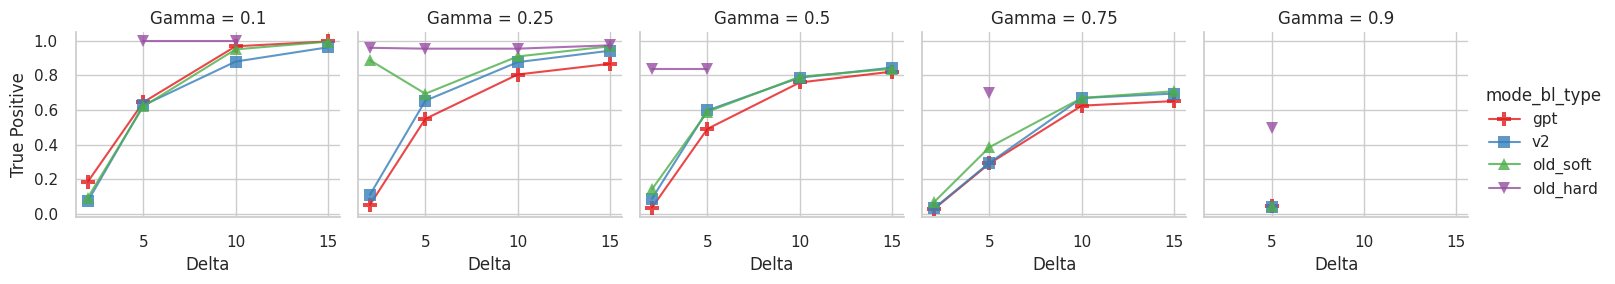

'for gamma, group in df_avg.groupby("gamma"):\n    print(f"Gamma: {gamma}") \n    display(group)'

In [139]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def combine_mode_bl_type (x):
  if pd.isnull (x ['bl_type']):
    return x ['mode']
  else:
    return '_'.join ([x ['mode'], x ['bl_type']])

df_avg = pd.read_csv(f"{save_csv_dir}/z_score_avg_{model_name}.csv")
sns.set_theme(style="whitegrid")
rs = np.random.RandomState(4)
df_clean = df_avg.drop(df_avg[(df_avg["mode"] == "new") | (df_avg["mode"] == "no")].index)

df_clean['mode_bl_type'] = df_clean.apply(combine_mode_bl_type, axis=1)

# 创建一个分面网格图对象，按照gamma值分列绘制子图
# sns.lineplot(x="delta", y="true_positive", style="logic", markers=["o", "s", "d", "^"], data=df_clean)

g = sns.FacetGrid(df_clean, col="gamma", hue="mode_bl_type", palette="Set1", hue_kws={"marker": ["P", "s", "^", "v"], "markersize": [10, 8, 8, 8], "markeredgewidth": [0, 0, 0, 0], "alpha": [0.8, 0.8, 0.8, 0.8]})
g.map(sns.lineplot, "delta", "true_positive", marker=True, dashes=False)

g.set_axis_labels("Delta", "True Positive")
g.set_titles("Gamma = {col_name}")

g.add_legend()

plt.savefig(f"{save_pic_dir}/{model_name}_search.pdf", dpi=400)
plt.show()

# Run this cell to print subframes of a groupby object, no further action is needed
'''for gamma, group in df_avg.groupby("gamma"):
    print(f"Gamma: {gamma}") 
    display(group)'''

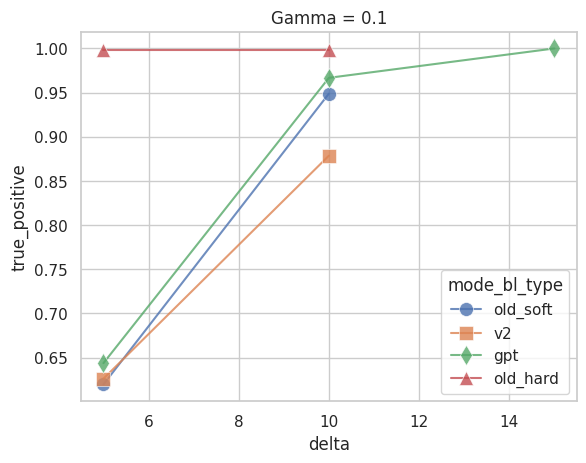

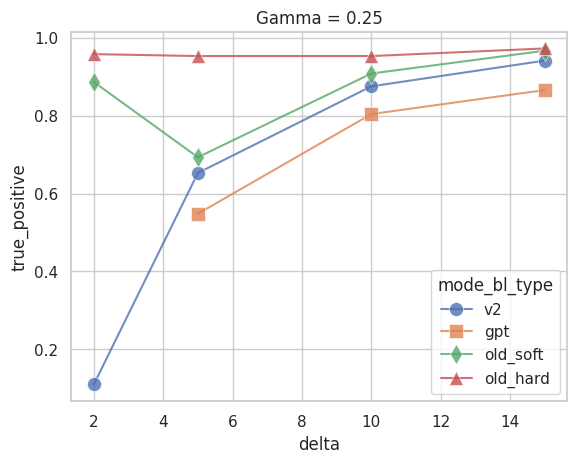

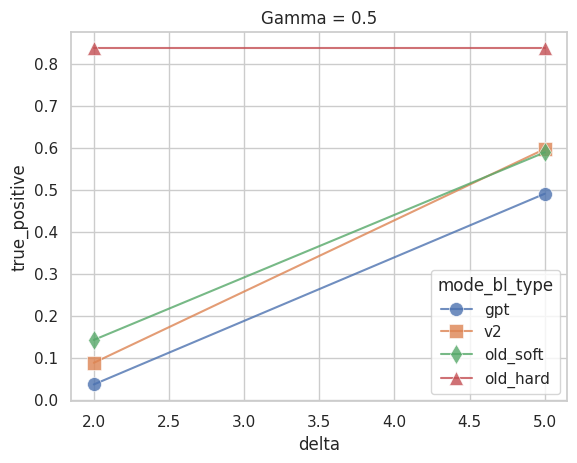

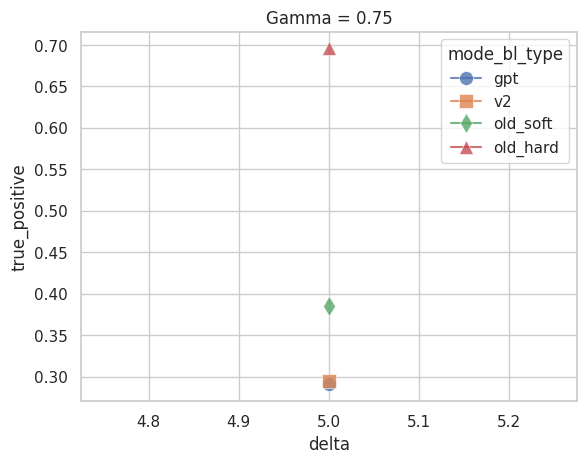

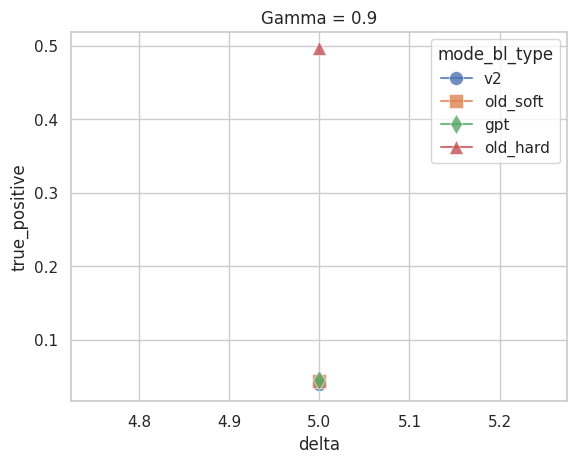

Gamma: 0.1


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
17,8,llama2-7b-chat-4k,old,0.1,5.0,4,soft,7.007897,0.619543,0.380457,2405,old_soft
18,10,llama2-7b-chat-4k,v2,0.1,5.0,4,NaN,7.014449,0.626040,0.373960,2404,v2
19,18,llama2-7b-chat-4k,gpt,0.1,5.0,4,NaN,11.259912,0.643659,0.356341,2405,gpt
28,22,llama2-7b-chat-4k,v2,0.1,10.0,4,NaN,36.181979,0.878586,0.121414,2405,v2
32,41,llama2-7b-chat-4k,old,0.1,10.0,4,soft,37.234036,0.948835,0.051165,2404,old_soft
36,1,llama2-7b-chat-4k,gpt,0.1,10.0,4,NaN,39.758137,0.966736,0.033264,2405,gpt
39,36,llama2-7b-chat-4k,old,0.1,10.0,4,hard,40.998949,0.998753,0.001247,2405,old_hard
40,32,llama2-7b-chat-4k,old,0.1,5.0,4,hard,40.998949,0.998753,0.001247,2405,old_hard
41,26,llama2-7b-chat-4k,gpt,0.1,15.0,4,NaN,39.948880,1.000000,0.000000,9,gpt


Gamma: 0.25


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
6,4,llama2-7b-chat-4k,v2,0.25,2.0,4,NaN,1.693713,0.109771,0.890229,2405,v2
14,20,llama2-7b-chat-4k,gpt,0.25,5.0,4,NaN,7.139749,0.548065,0.451935,2403,gpt
20,34,llama2-7b-chat-4k,v2,0.25,5.0,4,NaN,7.077833,0.652807,0.347193,2405,v2
21,38,llama2-7b-chat-4k,old,0.25,5.0,4,soft,7.640225,0.693139,0.306861,2405,old_soft
23,0,llama2-7b-chat-4k,gpt,0.25,10.0,4,NaN,18.718453,0.803995,0.196005,2403,gpt
26,21,llama2-7b-chat-4k,gpt,0.25,15.0,4,NaN,21.091143,0.865777,0.134223,2399,gpt
27,9,llama2-7b-chat-4k,v2,0.25,10.0,4,NaN,20.745836,0.875260,0.124740,2405,v2
29,16,llama2-7b-chat-4k,old,0.25,2.0,4,soft,14.551660,0.886486,0.113514,2405,old_soft
30,40,llama2-7b-chat-4k,old,0.25,10.0,4,soft,21.474891,0.908108,0.091892,2405,old_soft
31,39,llama2-7b-chat-4k,v2,0.25,15.0,4,NaN,22.373182,0.941348,0.058652,2404,v2


Gamma: 0.5


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
1,14,llama2-7b-chat-4k,gpt,0.5,2.0,4,NaN,0.923971,0.036175,0.963825,2405,gpt
5,24,llama2-7b-chat-4k,v2,0.5,2.0,4,NaN,1.700759,0.087734,0.912266,2405,v2
7,13,llama2-7b-chat-4k,old,0.5,2.0,4,soft,2.056198,0.142204,0.857796,2405,old_soft
12,7,llama2-7b-chat-4k,gpt,0.5,5.0,4,NaN,4.285467,0.490229,0.509771,2405,gpt
15,37,llama2-7b-chat-4k,old,0.5,5.0,4,soft,5.015976,0.588773,0.411227,2405,old_soft
16,19,llama2-7b-chat-4k,v2,0.5,5.0,4,NaN,5.105788,0.596674,0.403326,2405,v2
24,28,llama2-7b-chat-4k,old,0.5,5.0,4,hard,11.441775,0.836175,0.163825,2405,old_hard
25,5,llama2-7b-chat-4k,old,0.5,2.0,4,hard,11.441775,0.836175,0.163825,2405,old_hard


Gamma: 0.75


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
9,31,llama2-7b-chat-4k,gpt,0.75,5.0,4,NaN,2.597116,0.290644,0.709356,2405,gpt
10,23,llama2-7b-chat-4k,v2,0.75,5.0,4,NaN,2.808585,0.294802,0.705198,2405,v2
11,35,llama2-7b-chat-4k,old,0.75,5.0,4,soft,3.091542,0.384615,0.615385,2405,old_soft
22,3,llama2-7b-chat-4k,old,0.75,5.0,4,hard,6.351371,0.695634,0.304366,2405,old_hard


Gamma: 0.9


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
2,12,llama2-7b-chat-4k,v2,0.9,5.0,4,NaN,1.709520,0.039085,0.960915,2405,v2
3,27,llama2-7b-chat-4k,old,0.9,5.0,4,soft,1.496049,0.043659,0.956341,2405,old_soft
4,15,llama2-7b-chat-4k,gpt,0.9,5.0,4,NaN,1.550735,0.045738,0.954262,2405,gpt
13,17,llama2-7b-chat-4k,old,0.9,5.0,4,hard,3.396116,0.496050,0.503950,2405,old_hard


In [15]:
def plot_group(group):
  # 绘制每个组的折线图，以delta为x轴，true_positive为y轴，mode为不同类型的折线
  sns.lineplot(data=group, x="delta", y="true_positive", hue="mode_bl_type", style="mode_bl_type", dashes=False, markers=['o', 's', 'd', '^'], markersize=10, markeredgewidth=0.5, alpha=0.8)
  plt.title("Gamma = {}".format(group.name))
  plt.show()

df_clean.groupby("gamma").apply(plot_group)

for gamma, group in df_clean.groupby("gamma"):
    print(f"Gamma: {gamma}") 
    display(group)
    
    # group.plot()
    # plt.xlabel("Delta")
    # plt.ylabel("True Positive")
    # plt.title("True Positive by Gamma")
    # plt.show()

    

In [16]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_theme(style="ticks")

# # Create a dataset with many short random walks
# rs = np.random.RandomState(4)
# pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
# print(pos)
# pos -= pos[:, 0, np.newaxis]
# print(pos)
# step = np.tile(range(5), 20)
# walk = np.repeat(range(20), 5)
# df = pd.DataFrame(np.c_[pos.flat, step, walk],
#                   columns=["position", "step", "walk"])

# print(df)
# # Initialize a grid of plots with an Axes for each walk
# grid = sns.FacetGrid(df, col="walk", hue="walk", palette="tab20c",
#                      col_wrap=4, height=1.5)

# # Draw a horizontal line to show the starting point
# grid.refline(y=0, linestyle=":")

# # Draw a line plot to show the trajectory of each random walk
# grid.map(plt.plot, "step", "position", marker="o")

# # Adjust the tick positions and labels
# grid.set(xticks=np.arange(5), yticks=[-3, 3],
#          xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# # Adjust the arrangement of the plots
# grid.fig.tight_layout(w_pad=1)

Gen Radar Pic

[{}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 0.9975, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 1.0, 'L5:Open-Ended': 0.9875, 'L6:OverAll': 0.9950158586316268}, {'L1:(Short Q, Short A)': 0.9876543209876543, 'L2:(Short Q, Long A)': 1.0, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 1.0, 'L5:Open-Ended': 0.98875, 'L6:OverAll': 0.9945627548708654}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 0.925, 'L3:(Long Q, Short A)': 0.989010989010989, 'L4:(Long Q, Long A)': 0.9975, 'L5:Open-Ended': 0.9575, 'L6:OverAll': 0.9687358405074762}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 1.0, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 0.9975, 'L5:Open-Ended': 0.99875, 'L6:OverAll': 0.9990937924784776}]
[{'L1:(Short Q, Short A)': 17.825, 'L2:(Short Q, Long A)': 21.295, 'L3:(Long Q, Short A)': 37.505, 'L4:(Long Q, Long A)': 23.28, 'L5:Open-Ended': 54.66, 'L6:OverAll': 28.27444444444445}, {'L1:(Short Q, Short A)': 5.0, 'L2:(Short Q, Long A)': 12.

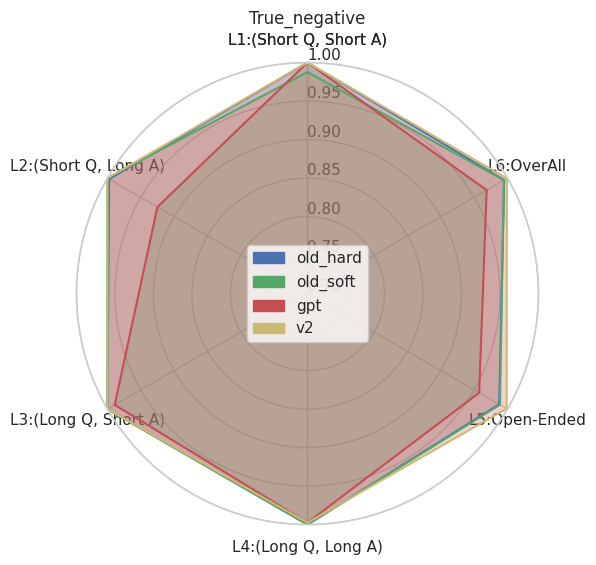

In [17]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print(tn_dict)
print(eval_dict)


scores_mode = ["no", "old_hard", "old_soft", "gpt", "v2"]
colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k']

new_mode_tn_dict = {}
for index, t in enumerate(tn_dict):
    if t:
        new_mode_tn_dict.update({scores_mode[index]:t})
        
new_mode_tn_list = list(new_mode_tn_dict.items())

# results = [{"English": 87, "Math": 79, "PE": 95, "Computer": 92, "Program": 85},
#            {"English": 80, "Math": 90, "PE": 91, "Computer": 85, "Program": 88}]

data_length = len(new_mode_tn_list[0][1].values())
print("data_length is", data_length)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
print(new_mode_tn_list[0][1].values())
print(new_mode_tn_list[0][0])
labels = [key for key in new_mode_tn_list[0][1].keys()]
print("labels is", labels)
score = [list(result[1].values()) for result in new_mode_tn_list]
print("score is", score)

# 使雷达图数据封闭
scores = []
patches = []
for i in range(len(score)):
    score_i = np.concatenate((score[i], [score[i][0]]))
    scores.append(score_i)
# score_a = np.concatenate((score[0], [score[0][0]]))
# score_b = np.concatenate((score[1], [score[1][0]]))
angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
for index, score_i in enumerate(scores):
    patch = mpatches.Patch(color=colors[index], label=list(new_mode_tn_dict.keys())[index])
    patches.append(patch)
    ax.plot(angles, score_i, color=colors[index])
    ax.fill(angles, score_i, alpha=0.25)
    
# ax.plot(angles, score_a, color='g')
# ax.plot(angles, score_b, color='b')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
# 设置雷达图的坐标刻度范围
ax.set_rlim(0.7, 1)
# 设置雷达图的坐标值显示角度，相对于起始角度的偏移量
ax.set_rlabel_position(0)
ax.set_title("True_negative")
ax.legend(handles=patches, loc='best')
# plt.legend(list(new_mode_tn_dict.keys()), loc='upper right')
plt.show()

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # 数据
# categories = ['A', 'B', 'C', 'D', 'E']
# values1 = [1, 2, 3, 4, 5]
# values2 = [5, 4, 3, 2, 1]
# 
# # 创建一个包含两个子图的图形
# fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True))
# 
# # 在第一个子图中绘制雷达图
# angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
# values1 = np.concatenate((values1,[values1[0]]))
# angles = np.concatenate((angles,[angles[0]]))
# ax1.plot(angles, values1, 'o-', linewidth=2)
# ax1.fill(angles, values1, alpha=0.25)
# ax1.set_title('Subplot 1', fontweight='bold', loc='left')
# 
# # 在第二个子图中绘制雷达图
# values2 = np.concatenate((values2,[values2[0]]))
# ax2.plot(angles, values2, 'o-', linewidth=2)
# ax2.fill(angles, values2, alpha=0.25)
# ax2.set_title('Subplot 2', fontweight='bold', loc='left')
# 
# # 添加总图例
# fig.legend(['Line 1', 'Line 2'], loc='lower center', ncol=2)
# 
# # 调整子图之间的间距
# plt.subplots_adjust(wspace=0.5)
# 
# # 显示图形
# plt.show()


[{}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 0.9975, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 1.0, 'L5:Open-Ended': 0.9875, 'L6:OverAll': 0.9950158586316268}, {'L1:(Short Q, Short A)': 0.9876543209876543, 'L2:(Short Q, Long A)': 1.0, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 1.0, 'L5:Open-Ended': 0.98875, 'L6:OverAll': 0.9945627548708654}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 0.925, 'L3:(Long Q, Short A)': 0.989010989010989, 'L4:(Long Q, Long A)': 0.9975, 'L5:Open-Ended': 0.9575, 'L6:OverAll': 0.9687358405074762}, {'L1:(Short Q, Short A)': 1.0, 'L2:(Short Q, Long A)': 1.0, 'L3:(Long Q, Short A)': 1.0, 'L4:(Long Q, Long A)': 0.9975, 'L5:Open-Ended': 0.99875, 'L6:OverAll': 0.9990937924784776}]
[{'L1:(Short Q, Short A)': 17.825, 'L2:(Short Q, Long A)': 21.295, 'L3:(Long Q, Short A)': 37.505, 'L4:(Long Q, Long A)': 23.28, 'L5:Open-Ended': 54.66, 'L6:OverAll': 28.27444444444445}, {'L1:(Short Q, Short A)': 5.0, 'L2:(Short Q, Long A)': 12.

/tmp/ipykernel_1690840/1346645314.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


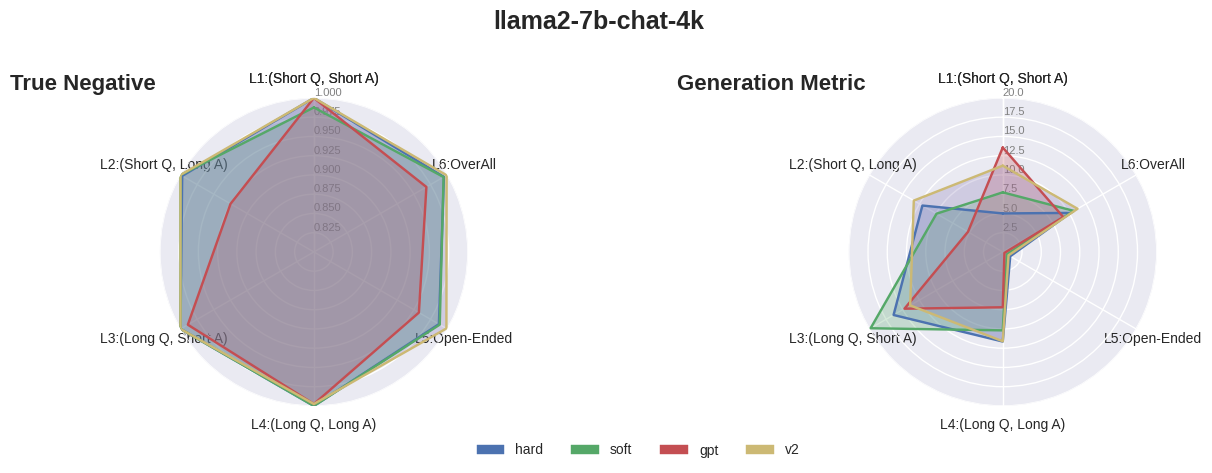

In [19]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print(tn_dict)
print(eval_dict)


scores_mode = ["no", "hard", "soft", "gpt", "v2"]
colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k']
plt.style.use('seaborn')

def draw(ax, start_point, end_point, para_dict, title):
    
    new_mode_para_dict = {}
    for index, t in enumerate(para_dict[1:]):
        new_mode_para_dict.update({scores_mode[index]:t})
        
    new_mode_para_list = list(new_mode_para_dict.items())
    data_length = len(new_mode_para_list[0][1].values())
    print("data_length is", data_length)
    
    angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
    print(new_mode_para_list[0][1].values())
    print(new_mode_para_list[0][0])
    labels = [key for key in new_mode_para_list[0][1].keys()]
    print("labels is", labels)
    score = [list(result[1].values()) for result in new_mode_para_list]
    
    print("score is", score)
    
    scores = []
    patches = []
    for i in range(len(score)):
        score_i = np.concatenate((score[i], [score[i][0]]))
        scores.append(score_i)
        
    angles = np.concatenate((angles, [angles[0]]))
    labels = np.concatenate((labels, [labels[0]]))
    
    for index, score_i in enumerate(scores):
        patch = mpatches.Patch(color=colors[index], label=list(new_mode_tn_dict.keys())[index].split("_")[-1])
        patches.append(patch)
        ax.plot(angles, score_i, color=colors[index])
        ax.fill(angles, score_i, alpha=0.25)
    
    ax.set_thetagrids(angles*180/np.pi, labels)
    # 设置雷达图的0度起始位置
    ax.set_theta_zero_location('N')
    # 设置雷达图的坐标刻度范围
    ax.set_rlim(start_point, end_point)
    ax.tick_params(axis='y', labelsize=8, labelcolor='gray')
    
    ax.set_rlabel_position(0)
    ax.set_title(title, fontweight='bold', x=-0.25, y=1, fontsize=16)
    # ax.title.set_position([-0.2, 1.0])
    return patches

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True),  figsize=(16, 4))
# ax1.set_size_inches(6, 4)
# ax2.set_size_inches(6, 4)
if "llama" in model_name:
    patches = draw(ax1, 0.8, 1, tn_dict, "True Negative") 
elif "internlm" in model_name:
    patches = draw(ax1, 0.9, 1, tn_dict, "True Negative")    

patches = draw(ax2, 0, 20, eval_dict, "Generation Metric")  

plt.subplots_adjust(wspace=0)
    
lgd=fig.legend(handles=patches, loc='lower center', ncols=4, bbox_to_anchor=(0.5,-0.05))
# plt.title(f'{model_name}', fontweight='bold', fontsize=18)
my_suptitle=fig.suptitle(f'{model_name}', x=0.475, y=1.1, fontweight='bold', fontsize=18)
# plt.legend(list(new_mode_tn_dict.keys()), loc='upper right')
plt.subplots_adjust(wspace=0.25)
plt.savefig(f"{save_pic_dir}/{model_name}_radar.pdf", dpi=100, bbox_inches='tight', bbox_extra_artists=(my_suptitle, lgd))
plt.savefig(f"{save_pic_dir}/{model_name}_radar.png", dpi=100, bbox_inches='tight', bbox_extra_artists=(my_suptitle, lgd))
# plt.savefig(model_name + "radar.png", dpi=100)

plt.show()   



### Gen HeatMap

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import gridspec
import numpy as np
import scipy
from scipy.interpolate import make_interp_spline
# import pandas as pd

In [33]:
# Read eval_{model_name}.csv
df_eval_llama = pd.read_csv(f"{save_csv_dir}/eval_llama2-7b-chat-4k.csv")
df_eval_internlm = pd.read_csv(f"{save_csv_dir}/eval_internlm-7b-8k.csv") 
df_eval_all = pd.concat([df_eval_llama.iloc[:, 1:], df_eval_internlm.iloc[:, 1:]], axis=0, ignore_index=True)

print(df_eval_all)
df_eval_all.to_csv(f"{save_csv_dir}/eval_all.csv")
# missions = df_eval_llama["mission_name"].unique()
id2dataset = {
    '1-1': 'konwledge_memorization',
    '1-2': 'konwledge_understanding',
    '2-1': 'longform_qa',
    '2-2': 'finance_qa',
    '3-1': 'hotpotqa',
    '3-2': 'lcc',
    '4-1': 'multi_news',
    '4-2': 'qmsum',
    '5-1': 'alpacafarm'
}

process_modes = {'internlm': modes0[0],
                 'internlm_hard': modes1[0],
                 'internlm_soft': modes2[0],
                 'internlm_gpt': modes3[0],
                 'internlm_v2': modes4[0],
                 'llama2': modes0[1],
                 'llama2_hard': modes1[1],
                 'llama2_soft': modes2[1],
                 'llama2_gpt': modes3[1],
                 'llama2_v2': modes4[1]}
all_eval_modes = []
for i in range(len(all_modes[0])):
    for j in range(len(all_modes)):
        all_eval_modes.append(all_modes[j][i])
# all_modes = all_modes.extend(modes3)
# missions = missions.tolist()
# missions.remove('avarage_mode')
# print(missions)

print(all_eval_modes)


            model_name                              mode  \
0    llama2-7b-chat-4k  llama2-7b-chat-4k_gpt_g0.1_d10.0   
1    llama2-7b-chat-4k  llama2-7b-chat-4k_gpt_g0.1_d10.0   
2    llama2-7b-chat-4k  llama2-7b-chat-4k_gpt_g0.1_d10.0   
3    llama2-7b-chat-4k  llama2-7b-chat-4k_gpt_g0.1_d10.0   
4    llama2-7b-chat-4k  llama2-7b-chat-4k_gpt_g0.1_d10.0   
..                 ...                               ...   
145     internlm-7b-8k      internlm-7b-8k_v2_g0.1_d10.0   
146     internlm-7b-8k      internlm-7b-8k_v2_g0.1_d10.0   
147     internlm-7b-8k      internlm-7b-8k_v2_g0.1_d10.0   
148     internlm-7b-8k      internlm-7b-8k_v2_g0.1_d10.0   
149     internlm-7b-8k      internlm-7b-8k_v2_g0.1_d10.0   

               mission_name      score  
0                       lcc  16.970000  
1                alpacafarm   0.250000  
2               longform_qa   4.520000  
3                multi_news   4.800000  
4                  hotpotqa  12.510000  
..                      ...      

In [55]:
draw_matrix = pd.DataFrame(index=id2dataset.keys(), columns=process_modes.keys())
for index, row in draw_matrix.iterrows():
    for process_mode in process_modes.keys():
        # key = set(str(process_mode))
        # ori_key = set()
        # print(id2dataset.get(index))
        # print(process_modes.get(process_mode))
        score = df_eval_all[(df_eval_all['mission_name'] == 
                             id2dataset.get(index)) & 
                            (df_eval_all['mode'] == process_modes.get(process_mode))]['score']
        # print(score)
        # print("#####################################")
        draw_matrix.loc[index, process_mode] = score.values[0]
        
print(draw_matrix)
draw_matrix.to_csv(f"{save_csv_dir}/heatmap.csv")


    internlm internlm_hard internlm_soft internlm_gpt internlm_v2 llama2  \
1-1    14.11          2.82          2.37         1.95        1.29   5.65   
1-2     38.5          0.79         10.12         4.46       20.62   30.0   
2-1    17.85         10.72           9.1         8.53        9.03  21.27   
2-2    18.93          8.45          6.08         7.07        6.26  21.32   
3-1    25.03          3.25          2.52          2.4        3.42  25.01   
3-2    38.19         20.14         18.65        20.48       28.12   50.0   
4-1    20.19          5.31          3.99         4.17        5.35  25.86   
4-2    15.44          7.41          5.26         6.21        5.64   20.7   
5-1    21.49          0.75          0.31          0.5         0.5  54.66   

    llama2_hard llama2_soft llama2_gpt llama2_v2  
1-1        1.06        1.67       1.82      1.15  
1-2        8.94       13.81      25.31     21.26  
2-1       10.47         8.1       4.52     13.22  
2-2       13.63       11.77       5

Index(['internlm', 'internlm_hard', 'internlm_soft', 'internlm_gpt',
       'internlm_v2', 'llama2', 'llama2_hard', 'llama2_soft', 'llama2_gpt',
       'llama2_v2'],
      dtype='object')
Index(['1-1', '1-2', '2-1', '2-2', '3-1', '3-2', '4-1', '4-2', '5-1'], dtype='object', name='Unnamed: 0')
Index(['internlm', 'internlm_hard', 'internlm_soft', 'internlm_gpt',
       'internlm_v2', 'llama2', 'llama2_hard', 'llama2_soft', 'llama2_gpt',
       'llama2_v2'],
      dtype='object')
Index(['1-1', '1-2', '2-1', '2-2', '3-1', '3-2', '4-1', '4-2', '5-1'], dtype='object')
The two DataFrames are different
Empty DataFrame
Columns: [internlm, internlm_hard, internlm_soft, internlm_gpt, internlm_v2, llama2, llama2_hard, llama2_soft, llama2_gpt, llama2_v2, _merge]
Index: []


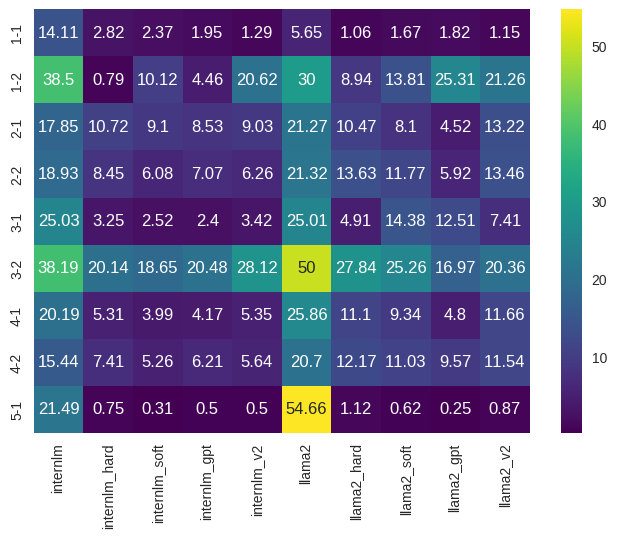

In [73]:
# draw_matrix.pivot(columns=process_modes.keys())
print(draw_matrix.columns)
print(draw_matrix.index)
# draw_matrix.reindex(draw_matrix1.index)
draw_matrix.index.name = "Unnamed: 0"
draw_matrix1 = pd.read_csv(f"{save_csv_dir}/heatmap.csv")

# 将第一列设置为索引列
draw_matrix1.set_index('Unnamed: 0', inplace=True)
draw_matrix1.index.name = None
draw_matrix1.columns.name = None
print(draw_matrix1.columns)
print(draw_matrix1.index)
# 判断两个 DataFrame 是否相同
if draw_matrix.equals(draw_matrix1):
    print("The two DataFrames are the same")
else:
    print("The two DataFrames are different")
# 比较两个 DataFrame 的不同之处
# 查找两个 DataFrame 之间的差异
df_diff = draw_matrix.merge(draw_matrix1, indicator=True, how='outer')
df_diff = df_diff[df_diff['_merge'] != 'both']

print(df_diff)

sns.heatmap(draw_matrix1, annot=True, fmt="g", cmap='viridis')
plt.show()

Index([0.001, 0.005, 0.01, 0.05, 'kk_k'], dtype='object', name='MutProb')


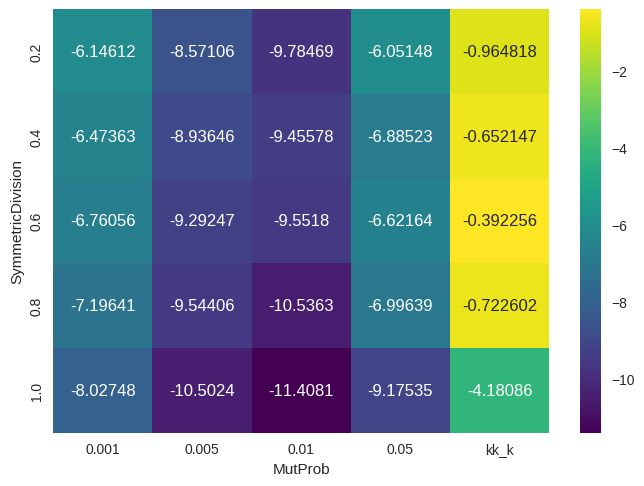

In [58]:
# df = pd.DataFrame({'MutProb': ['kk_k',
#   0.05, 0.01, 0.005, 0.001, 'kk_k', 0.05, 0.01, 0.005, 0.001, 'kk_k', 0.05, 0.01, 0.005, 0.001, 'kk_k', 0.05, 0.01, 0.005, 0.001, 'kk_k', 0.05, 0.01, 0.005, 0.001], 'SymmetricDivision': [1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2], 'test': ['sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule', 'sackin_yule'], 'value': [-4.1808639999999997, -9.1753490000000006, -11.408113999999999, -10.50245, -8.0274750000000008, -0.72260200000000008, -6.9963940000000004, -10.536339999999999, -9.5440649999999998, -7.1964070000000007, -0.39225599999999999, -6.6216390000000001, -9.5518009999999993, -9.2924690000000005, -6.7605589999999998, -0.65214700000000003, -6.8852289999999989, -9.4557760000000002, -8.9364629999999998, -6.4736289999999999, -0.96481800000000006, -6.051482, -9.7846860000000007, -8.5710630000000005, -6.1461209999999999]})

# # pivot the dataframe from long to wide form
# result = df.pivot(index='SymmetricDivision', columns='MutProb', values='value')

# print(result.columns)
# sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
# plt.show()

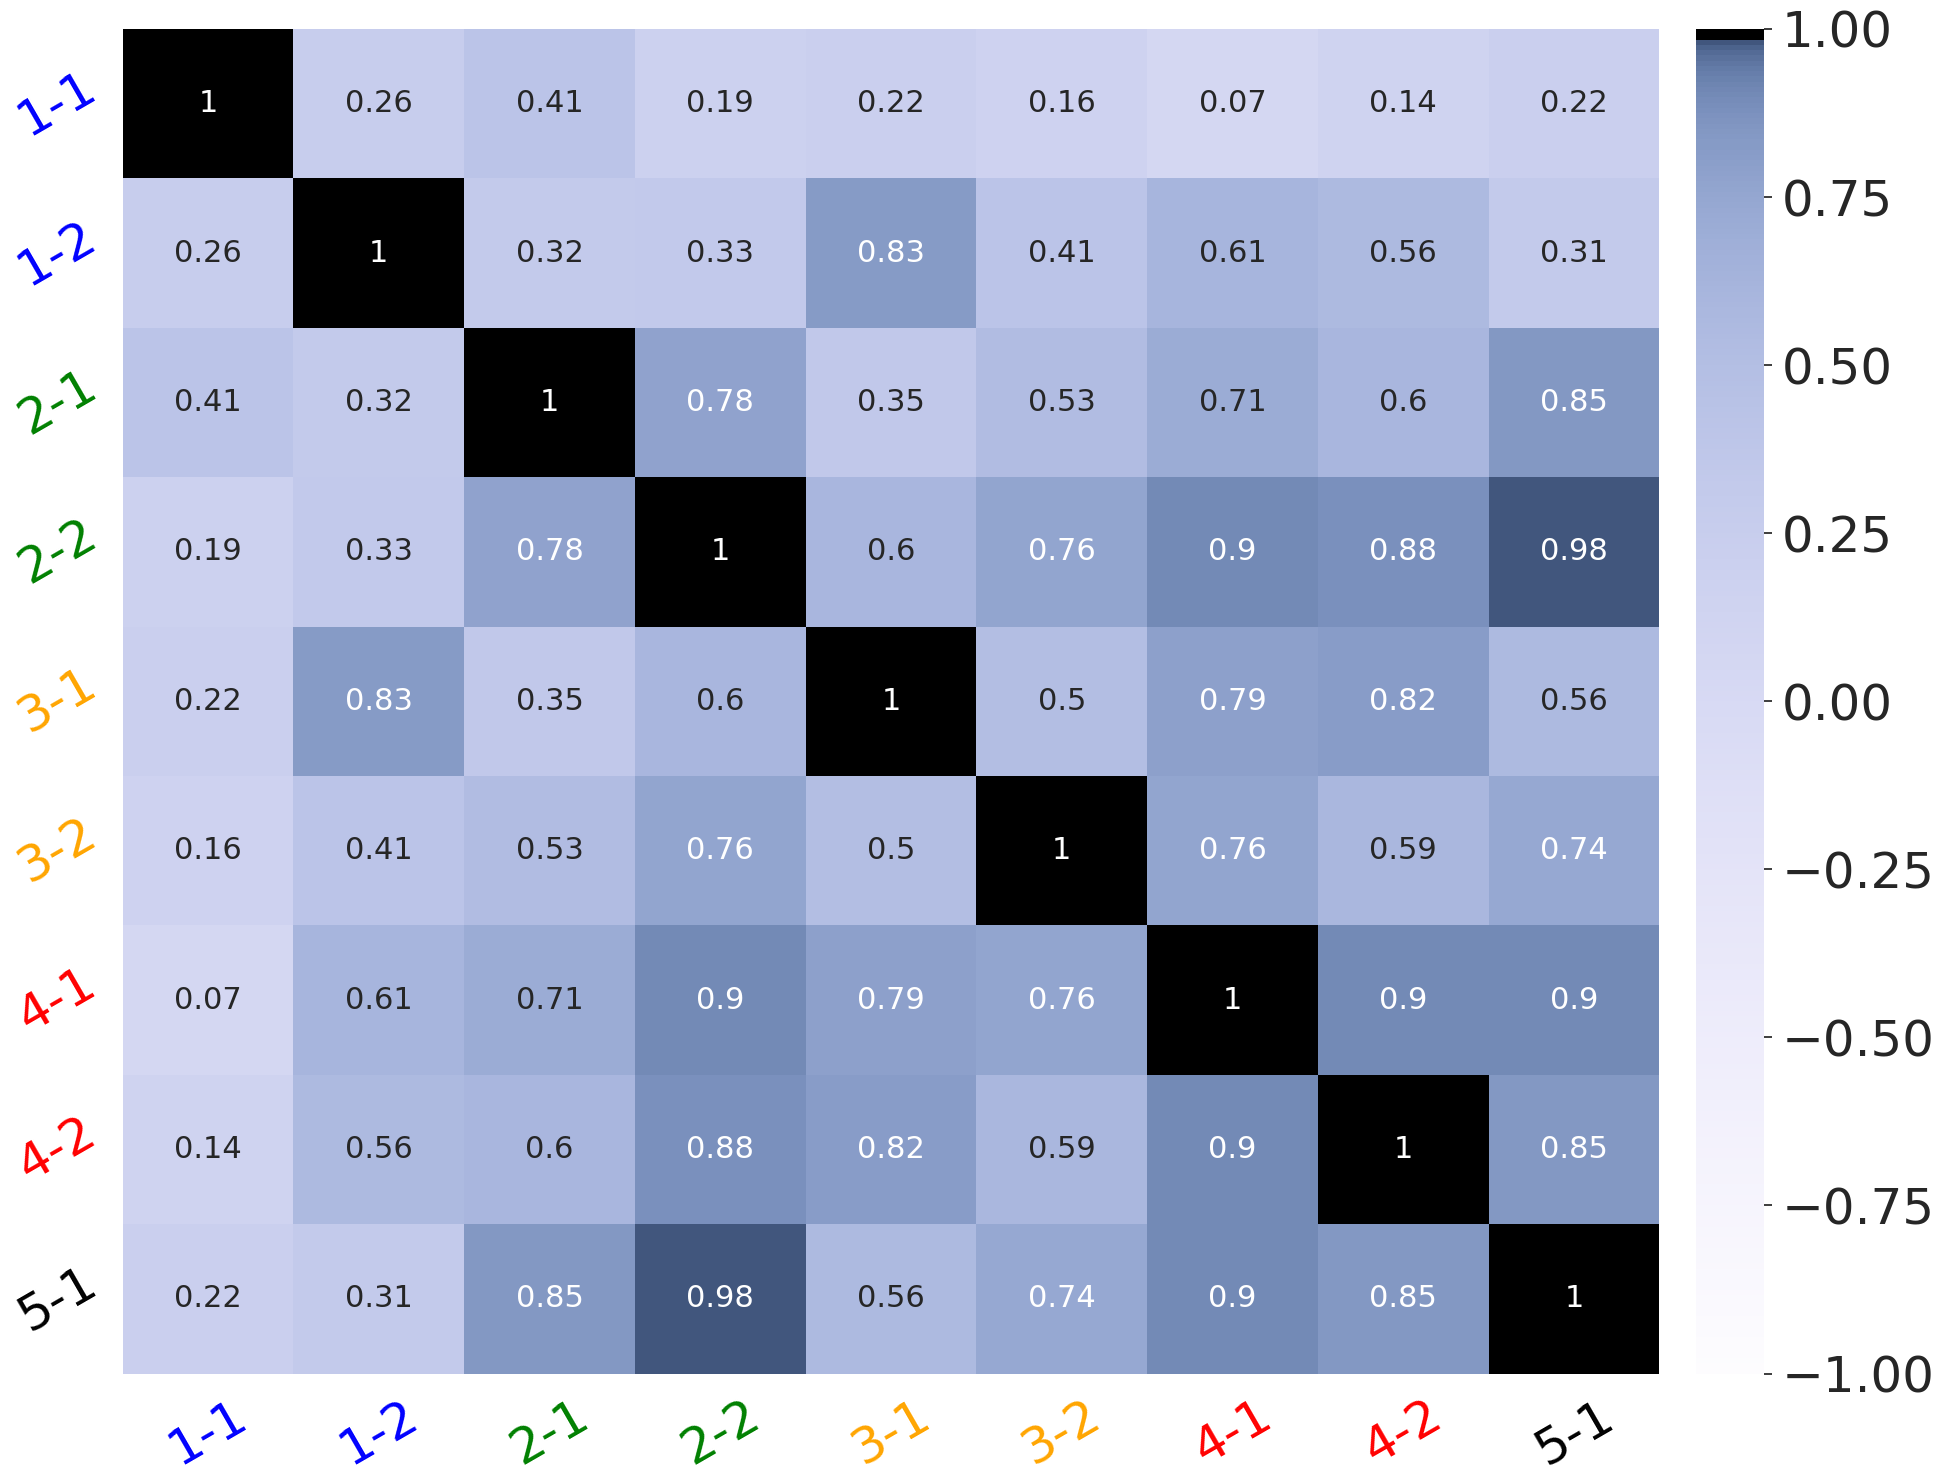

In [148]:
spr_scores = draw_matrix1.transpose().corr(method='spearman').round(2)
fig, ax = plt.subplots(figsize=(20,15))
colormap = sns.cubehelix_palette(start=2.8, rot=0.1, gamma=0.2, dark=-0.0, light=0.95, as_cmap=True)
hs = sns.heatmap(spr_scores, vmin=-1, vmax=1, annot=True, annot_kws={'size':22}, cmap=colormap, cbar_kws={"pad":0.02})
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=36)

# ax.set_title('Spearman\'s ρ between datasets with model performance as variables', fontsize=20)
ax.tick_params(labelsize=36, rotation=30)

y_colors=['blue']*2 + ['green']*2 + ['orange']*2 + ['red']*2 + ['black']*1
x_colors=['blue']*5 + ['green']*5
[t.set_color(y_colors[i]) for i,t in enumerate(ax.xaxis.get_ticklabels())]
[t.set_color(y_colors[i]) for i,t in enumerate(ax.yaxis.get_ticklabels())]
plt.tight_layout()
plt.show()
fig.savefig(f'{save_pic_dir}/heat_datasets.pdf')

### Scatters (MultipleLines)

In [146]:
def display_scatter_multilines(Xs, Ys, names=None, xlabels=None, ylabels=None, xlim=None, ylim=None,
                               titles=None, save_name=None, fit='polyfit'):
    
    titles = titles if titles is not None else [""]*len(Xs)
    xlabels = xlabels if xlabels is not None else [""]*len(Xs)
    ylabels = ylabels if ylabels is not None else [""]*len(Xs)
    cols = 2
    rows = len(Xs) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(20,15), tight_layout=True)
    if cols <= 1:
        axes = np.array([axes])
        
    for i, (X,Y) in enumerate(zip(Xs,Ys)):
        r, c = i // rows, i % rows
        title = titles[i] if titles is not None else None
        axes[r,c].set_title(title, fontsize=30)
        axes[r,c].set_xlabel(xlabels[i], fontsize=16)
        axes[r,c].set_ylabel(ylabels[i], fontsize=16)
        axes[r,c].xaxis.set_minor_locator(MultipleLocator(1))
        if xlim is not None: axes[r,c].set_xlim(xlim)
        if ylim is not None: axes[r,c].set_ylim(ylim)
#         axes[i].scatter(X, Y, s=25, c="#9370DB", alpha=0.5)
        axes[r,c].scatter(X, Y, c='gray', marker='o', edgecolors='k', s=40)
#         axes[i].set_yticks(np.unique(Y))
        # annotate points
        if names:
            for i in range(len(X)):
                plt.annotate(names[i], xy=(X[i],Y[i]), xytext=(X[i]-0.5,Y[i]+0.8), fontsize=6)
        axes[r,c].grid(alpha=0.2)
        axes[r,c].tick_params(labelsize=36)
        
        # Fit
        if fit != '':
            p = np.polyfit(X, Y, 1) # # p[0]=Gradient, p[1]=y-intercept
            model = np.poly1d(p)
            # Fit the model
            y_model = model(X)
            
            # Number of observations
            n = Y.size
            # Number of parameters: equal to the degree of the fitted polynomial (ie the
            # number of coefficients) plus 1 (ie the number of constants)
            m = p.size
            # Degrees of freedom (number of observations - number of parameters)
            dof = n - m
            # Significance level
            alpha = 0.05
            # We're using a two-sided test
            tails = 2
            # The percent-point function (aka the quantile function) of the t-distribution
            # gives you the critical t-value that must be met in order to get significance
            t_critical = scipy.stats.t.ppf(1 - (alpha / tails), dof)
            # Mean
            y_bar = np.mean(Y)
            # Coefficient of determination, R²
            R2 = np.sum((y_model - y_bar)**2) / np.sum((Y - y_bar)**2)
            
            # Calculate the residuals (the error in the data, according to the model)
            resid = Y - y_model
            # Chi-squared (estimates the error in data)
            chi2 = sum((resid / y_model)**2)
            # Reduced chi-squared (measures the goodness-of-fit)
            chi2_red = chi2 / dof
            # Standard deviation of the error
            std_err = np.sqrt(sum(resid**2) / dof)

            xlim = axes[r,c].get_xlim()
            ylim = axes[r,c].get_ylim()
            # Line of best fit
            axes[r,c].plot(np.array(xlim), p[1] + p[0] * np.array(xlim), label=f'Line of Best Fit, R² = {R2:.2f}')
            
            # Fit
            x_fitted = np.linspace(xlim[0], xlim[1], 300)
            y_fitted = np.polyval(p, x_fitted)
            # Confidence interval
            ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
            axes[r,c].fill_between(
                x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9cfe7', zorder=0,
                label=r'95% Confidence Interval'
            )
            axes[r,c].legend(fontsize=32, loc='upper left')
    
    # ax = plt.gca()
    # ax.set_yticks(Ys[0])
    plt.tight_layout()
    if save_name:
        fig.savefig(f"{save_pic_dir}/{save_name}", dpi=400)
    plt.show()

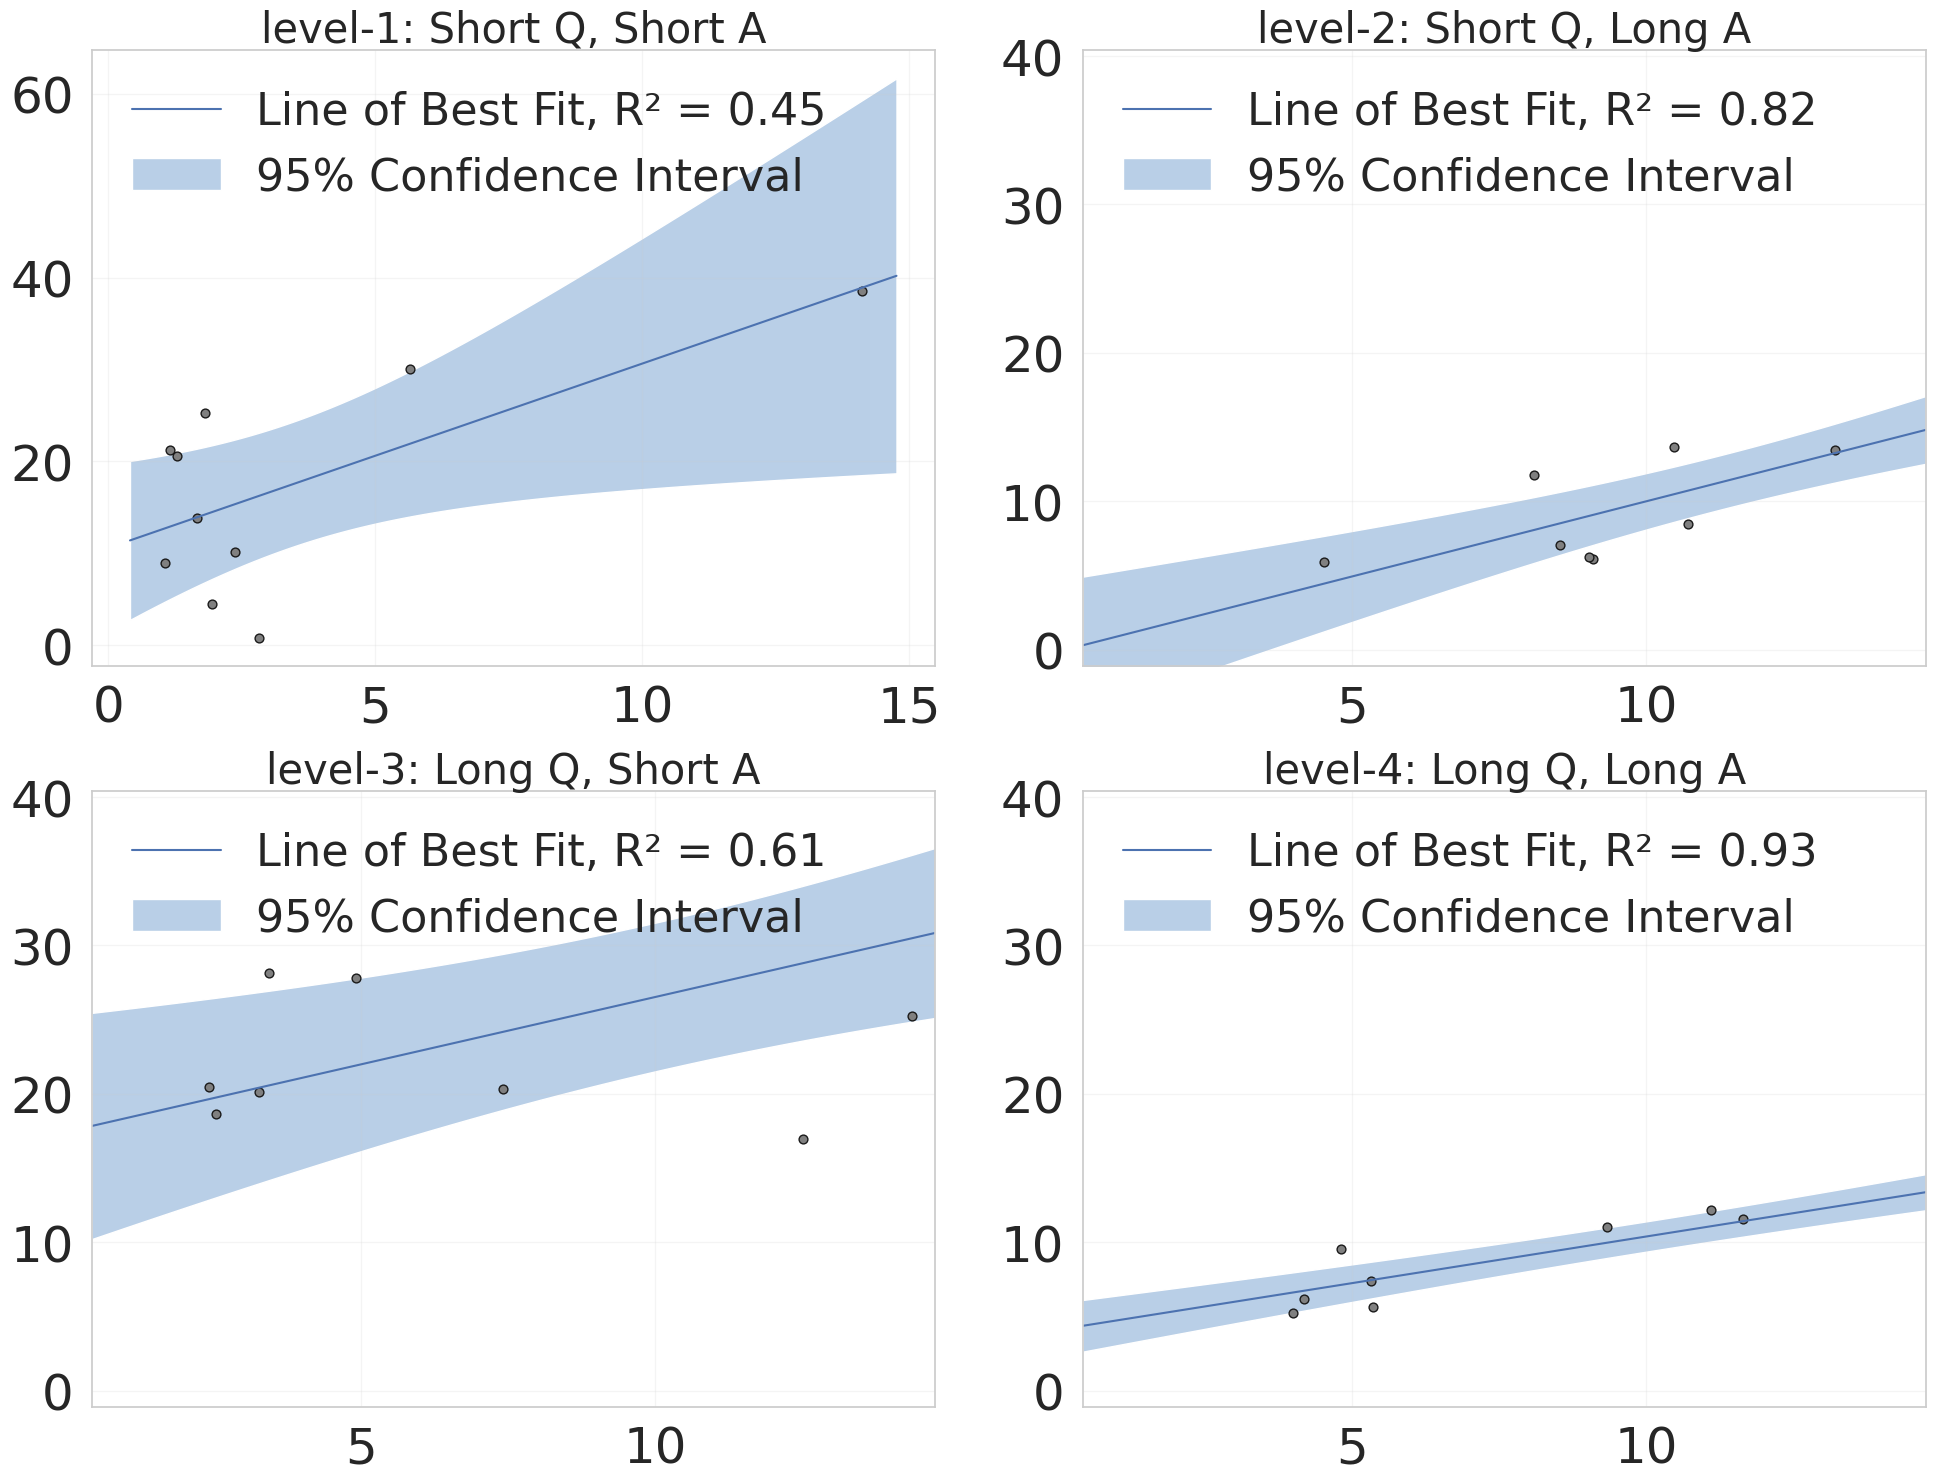

In [147]:
draw_matrix_T = draw_matrix1.transpose()

Xs = [draw_matrix_T['1-1'] , draw_matrix_T['2-1'], draw_matrix_T['3-1'], draw_matrix_T['4-1']]

Ys = [draw_matrix_T['1-2'], draw_matrix_T['2-2'], draw_matrix_T['3-2'], draw_matrix_T['4-2']]
display_scatter_multilines(Xs, Ys, titles=['level-1: Short Q, Short A', 'level-2: Short Q, Long A', 'level-3: Long Q, Short A', 'level-4: Long Q, Long A'], save_name='scatters_all.pdf')

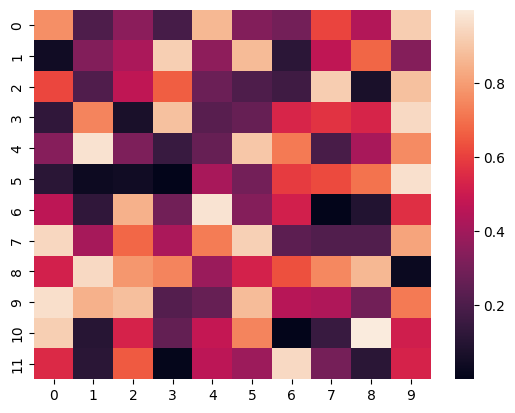

In [4]:
# uniform_data = np.random.rand(12,10)
# ax = sns.heatmap(uniform_data)
# plt.show()

In [70]:
import numpy as np

# 生成一个随机的二维数组
arr = np.random.rand(5, 3)

# 计算相关系数矩阵
corr = np.corrcoef(arr, rowvar=False)

# 显示相关系数矩阵
print(corr)


[[ 1.          0.37090558 -0.69758979]
 [ 0.37090558  1.          0.11863305]
 [-0.69758979  0.11863305  1.        ]]
